In [33]:
import torch
from transformers import AutoProcessor, AutoModelForCTC

import numpy as np

from datasets import load_dataset

from IPython.display import clear_output
clear_output()

In [5]:
# set espeak library path for macOS
import sys
if sys.platform == "darwin":
    from phonemizer.backend.espeak.wrapper import EspeakWrapper

    _ESPEAK_LIBRARY = "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
    EspeakWrapper.set_library(_ESPEAK_LIBRARY)

In [2]:
testset = load_dataset("mispeech/speechocean762", split="test") # pip install --upgrade huggingface_hub datasets

Generating test split: 100%|██████████| 2500/2500 [00:00<00:00, 6482.65 examples/s]


In [3]:
len(testset)

2500

In [12]:
ARPABET2IPA = {'AA':'ɑ','AE':'æ','AH':'ʌ','AH0':'ə','AO':'ɔ','AW':'aʊ','AY':'aɪ','EH':'ɛ','ER':'ɝ','ER0':'ɚ','EY':'eɪ','IH':'ɪ','IH0':'ɨ','IY':'i','OW':'oʊ','OY':'ɔɪ','UH':'ʊ','UW':'u','B':'b','CH':'tʃ','D':'d','DH':'ð','EL':'l̩ ','EM':'m̩','EN':'n̩','F':'f','G':'ɡ','HH':'h','JH':'dʒ','K':'k','L':'l','M':'m','N':'n','NG':'ŋ','P':'p','Q':'ʔ','R':'ɹ','S':'s','SH':'ʃ','T':'t','TH':'θ','V':'v','W':'w','WH':'ʍ','Y':'j','Z':'z','ZH':'ʒ'}
IPA_SUBSTITUTIONS = {
    'ɝ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
    'ɚ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
    'l̩': 'l',   # Remove syllabic marker from 'l̩'
    'm̩': 'm',   # Remove syllabic marker from 'm̩'
    'n̩': 'n',   # Remove syllabic marker from 'n̩'
    '̩': '',     # Remove syllabic marker
    'ɨ': 'i',    # Replace high central unrounded vowel with high front unrounded vowel
    ' ': '',     # Remove nasalization marker
}
for k in ARPABET2IPA.keys():
    if ARPABET2IPA[k] in IPA_SUBSTITUTIONS:
        ARPABET2IPA[k] = IPA_SUBSTITUTIONS[ARPABET2IPA[k]]

In [29]:
def extract_ipa_audio(sample):
    audio = sample["audio"]['array']
    words = sample["words"]
    phones = [p for w in words for p in w["phones"]]
    remove_stress = [''.join([p for p in phon if p.isalpha()]) for phon in phones]
    ipa = [ARPABET2IPA[p] for p in remove_stress]

    return ''.join(ipa), audio

mɑɹkɪzɡoʊɪŋtusiɛlɪfʌnt


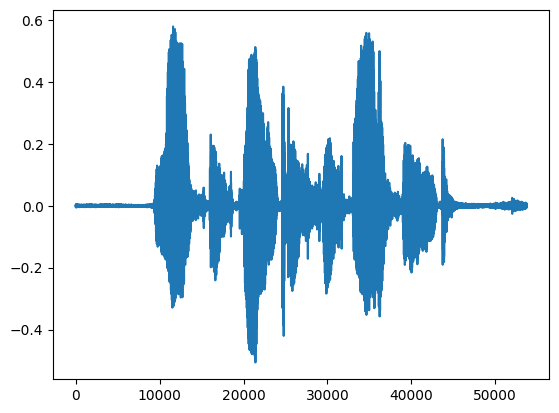

In [30]:
ipa, audio = extract_ipa_audio(testset[0])
import matplotlib.pyplot as plt
print(ipa)
plt.plot(audio)
plt.show()

In [60]:
# MODEL_ID = "KoelLabs/xlsr-timit-a1"
# MODEL_ID = "KoelLabs/xlsr-timit-b0"
# MODEL_ID = "KoelLabs/xlsr-timit-c0"
# MODEL_ID = "KoelLabs/xlsr-timit-d0"
# MODEL_ID = "KoelLabs/xlsr-timit-e0"
# MODEL_ID = "KoelLabs/xlsr-timit-b1"
# MODEL_ID = "KoelLabs/xlsr-timit-c1"
# MODEL_ID = "KoelLabs/xlsr-timit-d1"
# MODEL_ID = "KoelLabs/xlsr-timit-e1"
# MODEL_ID = "ginic/gender_split_70_female_4_wav2vec2-large-xlsr-53-buckeye-ipa"
# MODEL_ID = "mrrubino/wav2vec2-large-xlsr-53-l2-arctic-phoneme"
# MODEL_ID = "facebook/wav2vec2-lv-60-espeak-cv-ft"
MODEL_ID = "vitouphy/wav2vec2-xls-r-300m-timit-phoneme"
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
# DEVICE = 'cpu' # force cpu since we run out of memory with mps when using suitcase_corpus
torch.mps.empty_cache()
processor = AutoProcessor.from_pretrained(MODEL_ID)
model = AutoModelForCTC.from_pretrained(MODEL_ID).to(DEVICE)

In [31]:
TARGET_SAMPLE_RATE = processor.feature_extractor.sampling_rate
def transcribe_batch(batch):
    input_values = processor([extract_ipa_audio(x)[1] for x in batch], sampling_rate=TARGET_SAMPLE_RATE, return_tensors="pt", padding=True).input_values.type(torch.float32).to(DEVICE)
    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    return [processor.decode(ids) for ids in predicted_ids]

In [32]:
transcribe_batch([testset[0]])

['mɑkʔɪzɡoʊiŋtʊsiʔɛɾifint']

In [34]:
import panphon.distance

def cer(prediction, ground_truth):
    # Convert input lists to strings if they're lists
    if isinstance(prediction, list):
        prediction = "".join(prediction)
    if isinstance(ground_truth, list):
        ground_truth = "".join(ground_truth)

    # Handle empty strings
    if len(ground_truth) == 0:
        return 1.0 if len(prediction) > 0 else 0.0

    # Initialize the matrix
    matrix = np.zeros((len(prediction) + 1, len(ground_truth) + 1))

    # Fill first row and column
    for i in range(len(prediction) + 1):
        matrix[i, 0] = i
    for j in range(len(ground_truth) + 1):
        matrix[0, j] = j

    # Fill in the rest of the matrix
    for i in range(1, len(prediction) + 1):
        for j in range(1, len(ground_truth) + 1):
            if prediction[i - 1] == ground_truth[j - 1]:
                matrix[i, j] = matrix[i - 1, j - 1]
            else:
                substitution = matrix[i - 1, j - 1] + 1
                insertion = matrix[i, j - 1] + 1
                deletion = matrix[i - 1, j] + 1
                matrix[i, j] = min(substitution, insertion, deletion)

    # Calculate CER
    distance = matrix[len(prediction), len(ground_truth)]
    return distance / len(ground_truth)


def preprocess_ipa(ipa_string):
    """Preprocess an IPA string by removing unsupported symbols. Suggestions by David Mortensen, creator of panphon."""
    replacement_map = {
        "ɚ": "ɹ̩",  # Convert /ɚ/ to /ɹ/ (non-syllabic r)
        "ɝ": "ɹ",  # Convert /ɝ/ to /ɹ/ (non-syllabic r)
        "ː": "",  # Remove length mark (or duplicate previous vowel if length is important)
        "͡": "",  # Remove tie bar (or split into components if part of an affricate)
        "g": "ɡ",  # replace two versions of g, TIMIT uses ascii g and STANDARD IPA uses unicode g
    }
    processed_string = "".join(replacement_map.get(char, char) for char in ipa_string)

    return processed_string


def panphon_model_eval(label, predicted):
    label_sequence = preprocess_ipa(label)
    pred_sequence = preprocess_ipa(predicted)

    weighted_feature_dist = panphon.distance.Distance().weighted_feature_edit_distance(
        label_sequence, pred_sequence
    )
    cer_score = cer(predicted, label)

    return cer_score, weighted_feature_dist

In [61]:
BATCH_SIZE = 4
average_cer = 0
average_feature_distance = 0
amount = len(testset)
for i in range(0, amount, BATCH_SIZE):
    torch.mps.empty_cache()
    size = min(BATCH_SIZE, amount - i)
    transcriptions = transcribe_batch([testset[i+j] for j in range(size)])
    for j in range(size):
        cer_score, feature_distance = panphon_model_eval(extract_ipa_audio(testset[i+j])[0], transcriptions[j])
        average_cer += cer_score
        average_feature_distance += feature_distance

print(f"CER: {average_cer / amount}")
print(f"FER: {average_feature_distance / amount}")

CER: 0.724481719040464
FER: 25.811225


A1 CER: 0.5200123734215772
A1 FER: 34.841425

B0 CER: 0.4964618187991499
B0 FER: 31.7856

C0 CER: 0.523518326005636
C0 FER: 35.243925

D0 CER: 0.5019584750007547
D0 FER: 33.410825

E0 CER: 0.5036827946120923
E0 FER: 33.240875

B1 CER: 0.509668540315498
B1 FER: 32.062325

C1 CER: 0.522973851740122
C1 FER: 34.595825

D1 CER: 0.5019890725650029
D1 FER: 33.3339

E1 CER: 0.5181767662322538
E1 FER: 33.77795

GINIC CER: 0.46347369715476144
GINIC FER: 28.552325

Arctic Finetune CER: 0.6083775375446213
Arctic Finetune FER: 20.3091

Facebook 60 CER: 1.3656656869826551
Facebook 60 FER: 23.488125

Vitou CER: 0.724481719040464
Vitou FER: 25.811225